**Setup**

In [ ]:
import tensorflow as tf
tf.__version__

from imutils.object_detection import non_max_suppression
from google.colab.patches import cv2_imshow
from imutils import paths
import numpy as np
import time
import cv2
import os

!git clone https://github.com/dilhelh/opencv-text-detection.git

!python /content/opencv-text-detection/text_detection.py --image /content/opencv-text-detection/images/lebron_james.jpg \
	--east /content/opencv-text-detection/frozen_east_text_detection.pb





fatal: destination path 'opencv-text-detection' already exists and is not an empty directory.
[INFO] loading EAST text detector...
[INFO] text detection took 0.682125 seconds
qt.qpa.xcb: could not connect to display 
qt.qpa.plugin: Could not load the Qt platform plugin "xcb" in "/usr/local/lib/python3.10/dist-packages/cv2/qt/plugins" even though it was found.
This application failed to start because no Qt platform plugin could be initialized. Reinstalling the application may fix this problem.

Available platform plugins are: xcb.



**TF Lite Model Conversion and Quantization**

In [ ]:
!wget -q https://github.com/sayakpaul/Adventures-in-TensorFlow-Lite/releases/download/v0.11.0/coco_text_100.tar.gz
!tar xf coco_text_100.tar.gz

IMAGE_LIST = list(paths.list_images('/content/coco_text_100'))
IMG_SIZE = 320

def representative_dataset_gen():
    for image_path in IMAGE_LIST:
        image = cv2.imread(image_path)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
        image = image.astype("float32")
        mean = np.array([123.68, 116.779, 103.939][::-1], dtype="float32")
        image -= mean
        image = np.expand_dims(image, axis=0)
        yield [image]


quantization = "int8"
converter = tf.compat.v1.lite.TFLiteConverter.from_frozen_graph(
    graph_def_file='/content/opencv-text-detection/frozen_east_text_detection.pb',
    input_arrays=['input_images'],
    output_arrays=['feature_fusion/Conv_7/Sigmoid', 'feature_fusion/concat_3'],
    input_shapes={'input_images': [1, 320, 320, 3]}
)

converter.optimizations = [tf.lite.Optimize.DEFAULT]

if quantization=="float16":
    converter.target_spec.supported_types = [tf.float16]
elif quantization=="int8":
    converter.representative_dataset = representative_dataset_gen
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter.inference_input_type = tf.uint8
    converter.inference_output_type = tf.uint8

tflite_model = converter.convert()
open('east_model_{}.tflite'.format(quantization), 'wb').write(tflite_model)



!ls -lh *.tflite
!ls -lh /content/opencv-text-detection/frozen_east_text_detection.pb

-rw-r--r-- 1 root root 24M Nov  3 04:51 east_model_int8.tflite
-rw-r--r-- 1 root root 93M Nov  3 04:35 /content/opencv-text-detection/frozen_east_text_detection.pb


**Input Image**

In [ ]:
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    orig = image.copy()
    (H, W) = image.shape[:2]


    (newW, newH) = (320, 320)
    rW = W / float(newW)
    rH = H / float(newH)

    image = cv2.resize(image, (newW, newH))
    (H, W) = image.shape[:2]

    image = image.astype("float32")
    mean = np.array([123.68, 116.779, 103.939][::-1], dtype="float32")
    image -= mean
    image = np.expand_dims(image, 0)

    return image, orig, rW, rH


image2, orig2, rW2, rH2 = preprocess_image("/content/opencv-text-detection/images/plate2.jpg")

**Inference**

In [ ]:
def perform_inference(tflite_path, preprocessed_image):
    interpreter = tf.lite.Interpreter(model_path=tflite_path)
    input_details = interpreter.get_input_details()

    if input_details[0]["dtype"]==np.uint8:
        print("Integer quantization!")
        input_scale, input_zero_point = input_details[0]["quantization"]
        preprocessed_image = preprocessed_image / input_scale + input_zero_point
    preprocessed_image = preprocessed_image.astype(input_details[0]["dtype"])
    interpreter.allocate_tensors()
    interpreter.set_tensor(input_details[0]['index'], preprocessed_image)

    start = time.time()
    interpreter.invoke()
    print(f"Inference took: {time.time()-start} seconds")

    scores = interpreter.tensor(
        interpreter.get_output_details()[0]['index'])()
    geometry = interpreter.tensor(
        interpreter.get_output_details()[1]['index'])()

    return scores, geometry



quantization2 = "int8"
scores2, geometry2 = perform_inference(tflite_path=f'east_model_{quantization}.tflite',
                                     preprocessed_image=image2)


scores2.shape, geometry2.shape


scores2 = np.transpose(scores2, (0, 3, 1, 2))
geometry2 = np.transpose(geometry2, (0, 3, 1, 2))
scores2.shape, geometry2.shape

Integer quantization!
Inference took: 0.5680122375488281 seconds


((1, 1, 80, 80), (1, 5, 80, 80))

**Process Results**

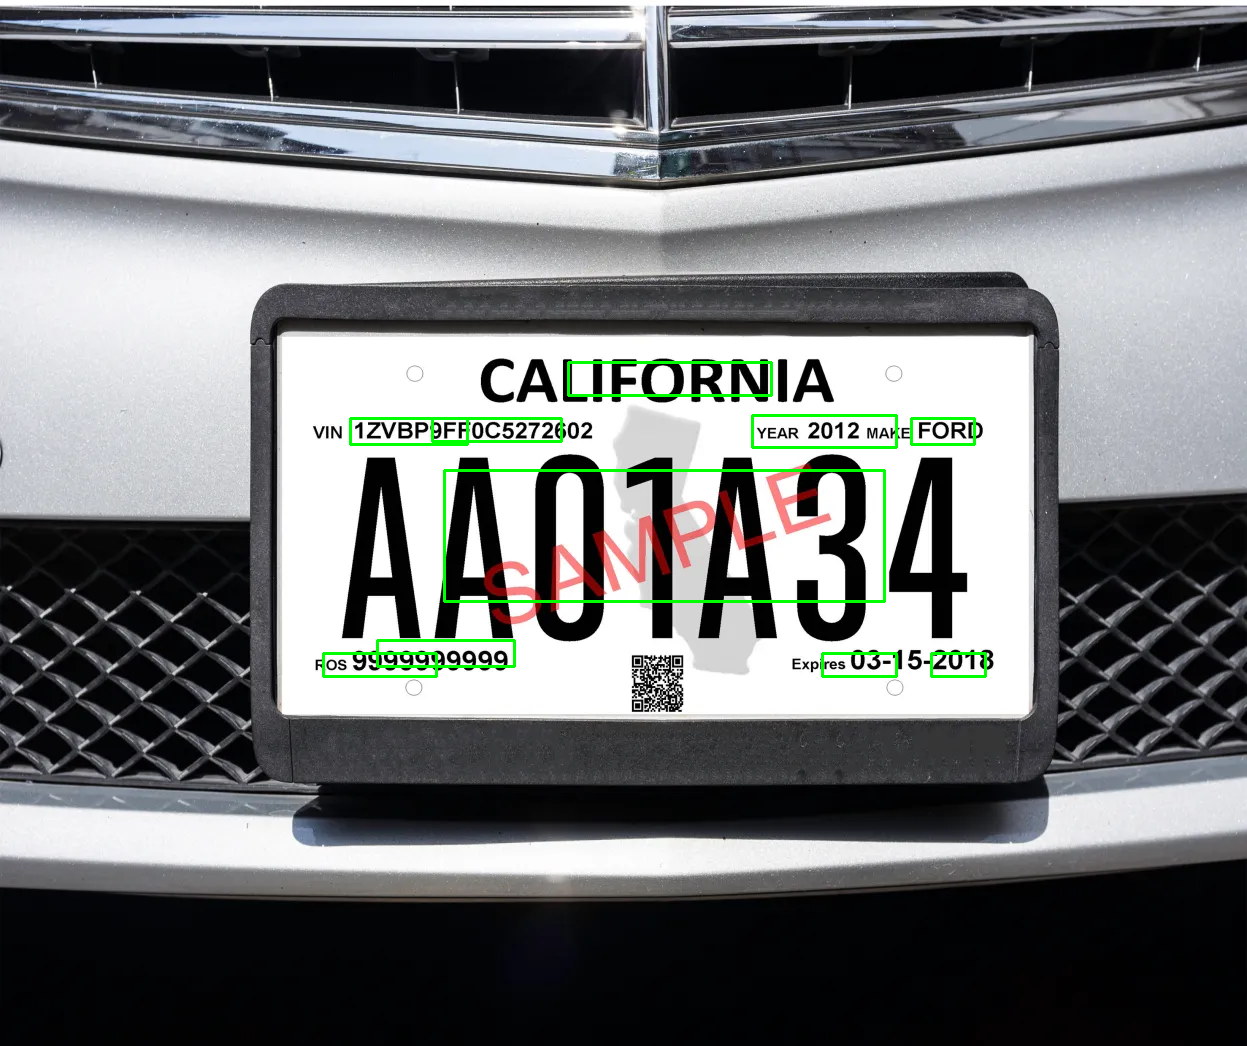

In [ ]:
def post_process(score, geo, ratioW, ratioH, original):

    (numRows, numCols) = score.shape[2:4]
    rects = []
    confidences = []


    for y in range(0, numRows):

        scoresData = score[0, 0, y]
        xData0 = geo[0, 0, y]
        xData1 = geo[0, 1, y]
        xData2 = geo[0, 2, y]
        xData3 = geo[0, 3, y]
        anglesData = geo[0, 4, y]

        for x in range(0, numCols):
            if scoresData[x] < 0.5:
                continue

            (offsetX, offsetY) = (x * 4.0, y * 4.0)


            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)


            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]


            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)


            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])


    boxes = non_max_suppression(np.array(rects), probs=confidences)

    for (startX, startY, endX, endY) in boxes:

        startX = int(startX * ratioW)
        startY = int(startY * ratioH)
        endX = int(endX * ratioW)
        endY = int(endY * ratioH)

        cv2.rectangle(original, (startX, startY), (endX, endY), (0, 255, 0), 2)

    cv2_imshow(original)



original2 = cv2.imread("/content/opencv-text-detection/images/plate2.jpg")
post_process(scores2, geometry2, rW2, rH2, original2)